In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import pandas as pd
import numpy as np
from sglm.helpers import filehelpers as fh, dfhelpers as dfh
from pathlib import Path
from collections import defaultdict
from tqdm.notebook import tqdm, trange
import scipy.stats
import matplotlib.pyplot as plt


In [4]:
base_keys = list({
                'gACH':(0,0),
                'rDA':(0,0),
                'gDA':(0,0),
                'photometrySideInIndexr':(0,0),
                'photometrySideInIndexnr':(0,0),
                'photometrySideInIndexAA':(0,0),
                'photometrySideInIndexAa':(0,0),
                'photometrySideInIndexaA':(0,0),
                'photometrySideInIndexaa':(0,0),
                'photometrySideInIndexAB':(0,0),
                'photometrySideInIndexAb':(0,0),
                'photometrySideInIndexaB':(0,0),
                'photometrySideInIndexab':(0,0),
                }.keys())
shortened_keys = [dfh.shorten_col_name(_) for _ in base_keys]

all_alignment_cols = [
#                         'SIAA',
                        'SIAa',
#                         'SIaA',
                        'SIaa',
#                         'SIAB',
                        'SIAb',
#                         'SIaB',
                        'SIab',
#                         'SIr',
                        'SInr', 
                     ]
# base_keys

In [5]:
def get_delta_list(event_srs, event_col, keep_srs):
    
    keep_eg_lst = []
    delta_keep_eg_lst = []

    rdc = []
    entry_num = np.arange(len(event_srs))
    event = np.where(event_srs.values == 1)
    assert len(event) == 1
    event = event[0]
    
    for iev, ev in enumerate(event):
        delta = entry_num - ev
        keep_eg = (delta >= -40)&(delta <= 100)&keep_srs
        delta_keep_eg = delta[keep_eg]
        keep_eg_lst.append(keep_eg)
        delta_keep_eg_lst.append(delta_keep_eg)

    return keep_eg_lst, delta_keep_eg_lst

# full_df = h5_lst[0]


In [6]:
# base_location = Path(r'/Users/josh/Documents/Harvard/GLM/sabatinilab-glm/sglm/outputs')
base_location = Path(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs')

# fig_folder_lst = [('Figure_1_2', 'f1*-ft'),
#                   ('Figure_3',   'f3*-ft'),
#                   ('Figure_4_g1',   'f4*-ft'),
#                   ('Figure_4_g2',   'f4*-ft'),
#                   ('Figure_5_g1',   'f5*-ft'),
#                   ('Figure_5_g2',   'f5*-ft'),
#                   ('Figure_5_g5',   'f5*-ft'),
#                  ]
fig_folder_lst = [('Figure_1_2', 'f1*-ft'),
#                   ('Figure_3',   'f3*-ft'),
#                   ('Figure_4_g1',   'f4*-ft'),
#                   ('Figure_4_g2',   'f4*-ft'),
#                   ('Figure_5_g1',   'f5*-ft'),
#                   ('Figure_5_g2',   'f5*-ft'),
#                   ('Figure_5_g5',   'f5*-ft'),
                 ]


combo_rdc = {}
for rn in [0,1,2,3,4,5,6]:
    for fig_folder in fig_folder_lst:
        print('fig_folder', fig_folder)

        load_folder = base_location / Path(fig_folder[0])
        # load_folder = base_location / Path(r'tmp')
        h5_recons_locations = str((load_folder / Path('all') / Path(fig_folder[1]) / Path(r'reconstructs\best_resids_*.h5')).resolve())

    #     print(h5_recons_locations)

    #     load_folder = base_location / Path(r'Figure_1_2')
    #     # load_folder = base_location / Path(r'tmp')
    #     h5_recons_locations = str((load_folder / Path(r'all\f1*-ft\reconstructs\best_resids_*.h5')).resolve())
    #     # h5_recons_locations = str((load_folder / Path(r'all/f1*-ft/reconstructs/best_resids_*.h5')).resolve())
    #     # load_folder = base_location / Path(r'Figure_3')
    #     # h5_beta_locations = str((load_folder / Path(r'all\f3*-ft\reconstructs\best_resids_*.h5')).resolve())
    #     # load_folder = base_location / Path(r'Figure_4_g1')
    #     # h5_beta_locations = str((load_folder / Path(r'all\f4*-ft\reconstructs\best_resids_*.h5')).resolve())
    #     # load_folder = base_location / Path(r'Figure_4_g2')
    #     # h5_beta_locations = str((load_folder / Path(r'all\f4*-ft\reconstructs\best_resids_*.h5')).resolve())
    #     # load_folder = base_location / Path(r'Figure_5_g1')
    #     # h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\reconstructs\best_resids_*.h5')).resolve())
    #     # load_folder = base_location / Path(r'Figure_5_g2')
    #     # h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\coefs\*_best_coeffs.h5')).resolve())
    #     # load_folder = base_location / Path(r'Figure_5_g5')
    #     # h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\coefs\*_best_coeffs.h5')).resolve())

        out_folder = base_location / Path(r'final_outputs')

        out_loc = str((out_folder).resolve())
        h5_recons_locations = glob.glob(h5_recons_locations)


        h5_lst = defaultdict(dict)
    #     run_id_dct = defaultdict(dict)


        for ih5, h5_coef_fn in enumerate(h5_recons_locations):
            h5f = pd.HDFStore(h5_coef_fn)
            h5fk = h5f.keys()
            for ik, key in enumerate(h5fk):
                key = key.replace('/', '')
                resp = key.split('_')[0]
                model_version = '_'.join(key.split('_')[3:]).split('_run_num')[0]


                if 'run_num' in key and f'run_num__{rn}' not in key:
                    continue
                if 'base_simple' not in model_version and 'base_words' not in model_version and '_to_' not in model_version and 'basis' not in key:
                    continue

    #             print('model_version', model_version)

    #             print(key, model_version)
    #             print(f'ih5, ik, model_version, key, h5_coef_fn - {ih5}, {ik}, {model_version}, {key}, {h5_coef_fn}')

                y_col = key.split('_')[0].replace(r'/', r'')

                h5_df = pd.read_hdf(h5f, key)

                h5_df.columns = [dfh.shorten_col_name(_) for _ in h5_df.columns]

                if 'dfrel_basis' != key.replace('/', ''):
                    h5_df.columns = [_.split('_')[0] for _ in h5_df.columns]
                    h5_df['true'] = h5_lst[ih5]['dfrel'][y_col]

                    h5_df['file_num'] = h5_lst[ih5]['dfrel']['file_num']

                    h5_df['dupe'] = h5_lst[ih5]['dfrel']['dupe']
                    h5_df['wi_trial_keep'] = h5_lst[ih5]['dfrel']['wi_trial_keep']

                    h5_lst[ih5][key] = h5_df
                else:
                    h5_lst[ih5]['dfrel'] = h5_df

    #     for k in h5_lst:
    #         for kk in h5_lst[k]:
    #             print(k, kk)



        for ih5 in h5_lst:
    #     for y_col in ['gACH', 'rDA', 'gDA']:
    #             fig,axes = plt.subplots(5,2,figsize=(10,30))

            for key in h5_lst[ih5]:
    #         for y_col in ['gACH', 'rDA', 'gDA']:
    #         for ih5 in h5_lst:
                if key == 'dfrel':
                    continue

                for iac, alignment_col in enumerate(all_alignment_cols):
        #                 ic, ir = iac%2, iac//2
        #                 ax = axes[ir, ic]


                    resp = key.split('_')[0].replace('/', '')
                    model_version = '_'.join(key.split('_')[3:]).split('_run_num')[0]
                    y_col = key.split('_')[0].replace(r'/', r'')

                    dupe = h5_lst[ih5]['dfrel']['dupe']
                    dfrel_basis = h5_lst[ih5]['dfrel'].loc[~dupe]
                    dfrel_basis_run = h5_lst[ih5][key].loc[~dupe]

                    print('Pulling delta list')
                    keep_rows, assoc_deltas = get_delta_list(dfrel_basis[alignment_col], alignment_col, ((dfrel_basis_run['holdout']==1)).astype(bool))
                    rdc_lst = defaultdict(list)
                    for entry_num in trange(len(keep_rows)):
                        keep_row_single = keep_rows[entry_num]
                        deltas = assoc_deltas[entry_num]
                        rdc_df = dfrel_basis_run.loc[keep_row_single].set_index(deltas)

                        if rdc_df['file_num'].nunique() > 1:
                            continue

                        reconstruction_data_list = []

                        for bootstrap_col in ['true', 'pred']:
                            rdc_lst[bootstrap_col].append(rdc_df[[bootstrap_col]])

    #                 print('keys', rdc_lst.keys())

    #                 seed = np.random.randint(1000000000)
    #                 for bootstrap_col in (rdc_lst):
    #                     tmp_rdc = pd.concat(rdc_lst[bootstrap_col], axis=1).sort_index()

    #                     reconstruction_data_list = []
    #                     for delta in (tmp_rdc.index):
    #                         row = tmp_rdc.loc[delta].dropna().values
    #                         bs = scipy.stats.bootstrap((row,), np.mean, n_resamples=9999,
    #     #                     bs = scipy.stats.bootstrap((row,), np.mean, n_resamples=1000,
    #                                                    batch=None, vectorized=True, paired=False,
    #                                                    axis=0, confidence_level=0.95, method='BCa',
    #                                                    random_state=seed)

    #                         mn_val = row.mean()
    #                         rtup = (bootstrap_col, delta, bs.confidence_interval.low, mn_val, bs.confidence_interval.high)

    #                         reconstruction_data_list.append(rtup)

    #                     tmp_combo_rdc = pd.DataFrame(reconstruction_data_list, columns=['basis_column', 'delta', 'lb', 'mn', 'ub']).set_index('delta')
    #                     combo_rdc[f'{alignment_col}_{bootstrap_col}'] = tmp_combo_rdc.drop('basis_column',axis=1)
                            combo_rdc[f'{alignment_col}_{bootstrap_col}_{ih5}_{key}_{rn}'] = pd.concat(rdc_lst[bootstrap_col], axis=1)

#                 combo_rdc.columns = ['_'.join(_).replace('_true_', '_T_').replace('_pred_', '_P_') for _ in combo_rdc.columns]
#                 combo_rdc.to_csv(str((Path(out_loc) / f'{load_folder.parts[-1]}-reconstruct-{y_col}={model_version}-rn{rn}.csv').resolve()))
                break
            break
        break


fig_folder ('Figure_1_2', 'f1*-ft')
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

fig_folder ('Figure_1_2', 'f1*-ft')
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

fig_folder ('Figure_1_2', 'f1*-ft')
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

fig_folder ('Figure_1_2', 'f1*-ft')
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

fig_folder ('Figure_1_2', 'f1*-ft')
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

fig_folder ('Figure_1_2', 'f1*-ft')
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

fig_folder ('Figure_1_2', 'f1*-ft')
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

In [7]:
mn = {}
for key in combo_rdc:
#     print(key)
#     display(combo_rdc[key].sort_index())
#     if 'SInr' in key:
#         print(key)
    
    ks = key.split('_')
    ac = ks[0]
    crv = ks[1]
    rn = ks[-1]
    
    k = f'{crv}_{ac}_{rn}'
    print(k)
    
    df = combo_rdc[key].sort_index()
#     mn[k] = (df.sum(axis=1), (~df.isna()).sum(axis=1))
    mn[k] = df.mean(axis=1)

true_SIAa_0
pred_SIAa_0
true_SIaa_0
pred_SIaa_0
true_SIAb_0
pred_SIAb_0
true_SIab_0
pred_SIab_0
true_SInr_0
pred_SInr_0
true_SIAa_1
pred_SIAa_1
true_SIaa_1
pred_SIaa_1
true_SIAb_1
pred_SIAb_1
true_SIab_1
pred_SIab_1
true_SInr_1
pred_SInr_1
true_SIAa_2
pred_SIAa_2
true_SIaa_2
pred_SIaa_2
true_SIAb_2
pred_SIAb_2
true_SIab_2
pred_SIab_2
true_SInr_2
pred_SInr_2
true_SIAa_3
pred_SIAa_3
true_SIaa_3
pred_SIaa_3
true_SIAb_3
pred_SIAb_3
true_SIab_3
pred_SIab_3
true_SInr_3
pred_SInr_3
true_SIAa_4
pred_SIAa_4
true_SIaa_4
pred_SIaa_4
true_SIAb_4
pred_SIAb_4
true_SIab_4
pred_SIab_4
true_SInr_4
pred_SInr_4
true_SIAa_5
pred_SIAa_5
true_SIaa_5
pred_SIaa_5
true_SIAb_5
pred_SIAb_5
true_SIab_5
pred_SIab_5
true_SInr_5
pred_SInr_5
true_SIAa_6
pred_SIAa_6
true_SIaa_6
pred_SIaa_6
true_SIAb_6
pred_SIAb_6
true_SIab_6
pred_SIab_6
true_SInr_6
pred_SInr_6


In [8]:
sorted(list(mn.keys()))

['pred_SIAa_0',
 'pred_SIAa_1',
 'pred_SIAa_2',
 'pred_SIAa_3',
 'pred_SIAa_4',
 'pred_SIAa_5',
 'pred_SIAa_6',
 'pred_SIAb_0',
 'pred_SIAb_1',
 'pred_SIAb_2',
 'pred_SIAb_3',
 'pred_SIAb_4',
 'pred_SIAb_5',
 'pred_SIAb_6',
 'pred_SIaa_0',
 'pred_SIaa_1',
 'pred_SIaa_2',
 'pred_SIaa_3',
 'pred_SIaa_4',
 'pred_SIaa_5',
 'pred_SIaa_6',
 'pred_SIab_0',
 'pred_SIab_1',
 'pred_SIab_2',
 'pred_SIab_3',
 'pred_SIab_4',
 'pred_SIab_5',
 'pred_SIab_6',
 'pred_SInr_0',
 'pred_SInr_1',
 'pred_SInr_2',
 'pred_SInr_3',
 'pred_SInr_4',
 'pred_SInr_5',
 'pred_SInr_6',
 'true_SIAa_0',
 'true_SIAa_1',
 'true_SIAa_2',
 'true_SIAa_3',
 'true_SIAa_4',
 'true_SIAa_5',
 'true_SIAa_6',
 'true_SIAb_0',
 'true_SIAb_1',
 'true_SIAb_2',
 'true_SIAb_3',
 'true_SIAb_4',
 'true_SIAb_5',
 'true_SIAb_6',
 'true_SIaa_0',
 'true_SIaa_1',
 'true_SIaa_2',
 'true_SIaa_3',
 'true_SIaa_4',
 'true_SIaa_5',
 'true_SIaa_6',
 'true_SIab_0',
 'true_SIab_1',
 'true_SIab_2',
 'true_SIab_3',
 'true_SIab_4',
 'true_SIab_5',
 'true_S

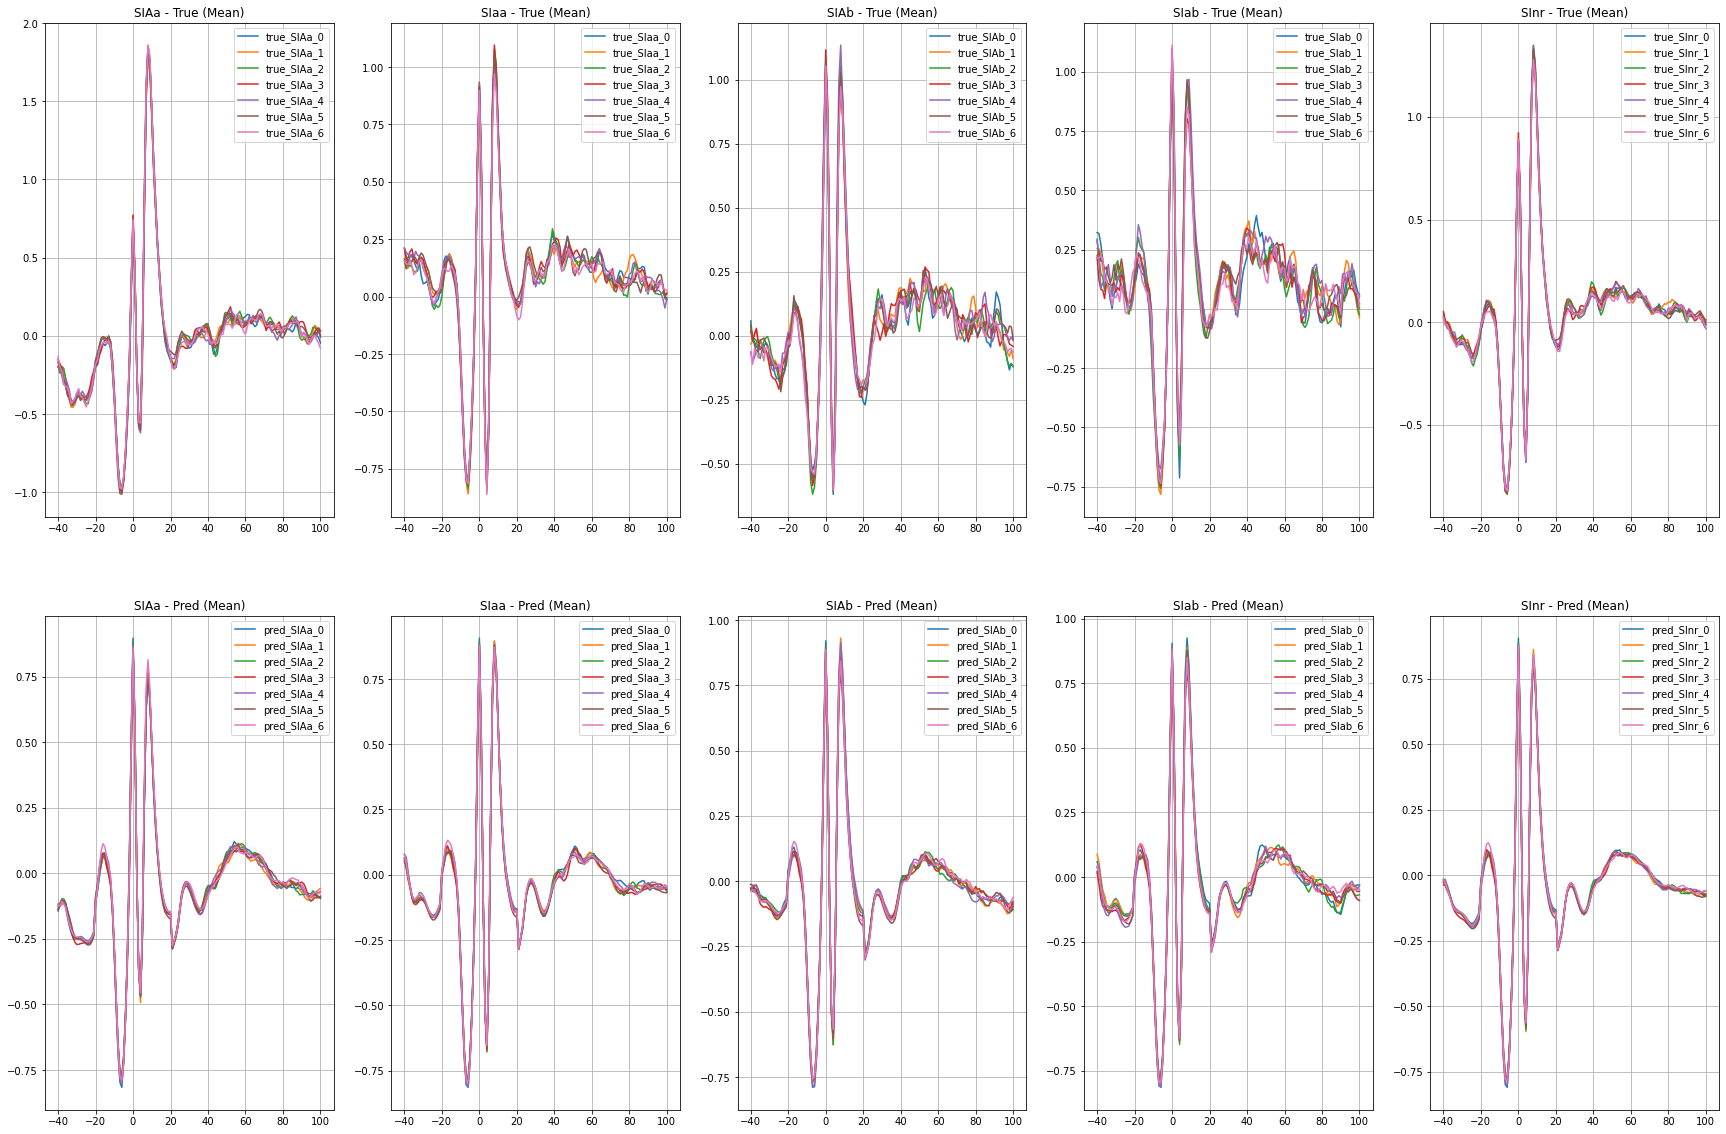

In [9]:
import matplotlib.pyplot as plt


mndf = pd.DataFrame(mn)
mndf = mndf[sorted([_ for _ in mndf.columns])]

fig, axes = plt.subplots(2,len(all_alignment_cols),figsize=(30, 20))
fig.set_facecolor('w')
for iac, ac in enumerate(all_alignment_cols):
    mndft = mndf[[_ for _ in mndf.columns if 'true' in _ and ac in _]]
    mndfp = mndf[[_ for _ in mndf.columns if 'pred' in _ and ac in _]]
    
    mndft.plot(ax=axes[0, iac])
    mndfp.plot(ax=axes[1, iac])
    
    axes[0, iac].grid(True)
    axes[0, iac].set_title(f'{ac} - True (Mean)')
    
    axes[1, iac].grid(True)
    axes[1, iac].set_title(f'{ac} - Pred (Mean)')
    

In [10]:
comparison = 'pred' #'true'
trig = False


rn_lst = []
for rn_view in [0, 1, 2]:
    for key in mn:
        if 'SInr' not in key and comparison in key and rn_view in key:
            sm, cnt = mn[key]
#             if not trig:
#                 ts = sm
#                 tc = cnt
#                 trig = True
#             else:
#                 ts += sm
#                 tc += cnt
            
            dct['key']

print(ts/tc)
print((mn[f'SInr_{comparison}'][0]/mn[f'SInr_{comparison}'][1]))
np.allclose(ts/tc, (mn[f'SInr_{comparison}'][0]/mn[f'SInr_{comparison}'][1]))

TypeError: 'in <string>' requires string as left operand, not int

In [ ]:
# list(combo_rdc.keys())

In [ ]:
# for k in h5_lst:
#     for kk in h5_lst[k]:
#         print(k, kk)
# #         display(h5_lst[k][kk])
# #     break

In [ ]:
# [len(h5_lst['dfrel'][_]) for _ in range(len(h5_lst['dfrel']))], [len(h5_lst[y_col][_]) for _ in range(len(h5_lst[y_col]))]

In [ ]:
# len(dupe), len(h5_lst[y_col][i])

In [ ]:
combo_rdc[[_ for _ in combo_rdc.columns if '_mn' in _]].plot()

In [ ]:
y_col, model_version

In [ ]:
# run_id_dct[y_col]

In [ ]:
# # base_location = Path(r'/Users/josh/Documents/Harvard/GLM/sabatinilab-glm/sglm/outputs')
# base_location = Path(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs')

# fig_folder_lst = [#('Figure_1_2', 'f1*-ft'),
#                   #('Figure_3',   'f3*-ft'),
#                   #('Figure_4_g1',   'f4*-ft'),
#                   ('Figure_4_g2',   'f4*-ft'),
#                   #('Figure_5_g1',   'f5*-ft'),
#                   #('Figure_5_g2',   'f5*-ft'),
#                   #('Figure_5_g5',   'f5*-ft'),
#                  ]

# for fig_folder in fig_folder_lst:
#     print('fig_folder', fig_folder)
    
#     load_folder = base_location / Path(fig_folder[0])
#     # load_folder = base_location / Path(r'tmp')
#     h5_recons_locations = str((load_folder / Path('all') / Path(fig_folder[1]) / Path(r'reconstructs\best_resids_*.h5')).resolve())
    
#     print(h5_recons_locations)
    
# #     load_folder = base_location / Path(r'Figure_1_2')
# #     # load_folder = base_location / Path(r'tmp')
# #     h5_recons_locations = str((load_folder / Path(r'all\f1*-ft\reconstructs\best_resids_*.h5')).resolve())
# #     # h5_recons_locations = str((load_folder / Path(r'all/f1*-ft/reconstructs/best_resids_*.h5')).resolve())
# #     # load_folder = base_location / Path(r'Figure_3')
# #     # h5_beta_locations = str((load_folder / Path(r'all\f3*-ft\reconstructs\best_resids_*.h5')).resolve())
# #     # load_folder = base_location / Path(r'Figure_4_g1')
# #     # h5_beta_locations = str((load_folder / Path(r'all\f4*-ft\reconstructs\best_resids_*.h5')).resolve())
# #     # load_folder = base_location / Path(r'Figure_4_g2')
# #     # h5_beta_locations = str((load_folder / Path(r'all\f4*-ft\reconstructs\best_resids_*.h5')).resolve())
# #     # load_folder = base_location / Path(r'Figure_5_g1')
# #     # h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\reconstructs\best_resids_*.h5')).resolve())
# #     # load_folder = base_location / Path(r'Figure_5_g2')
# #     # h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\coefs\*_best_coeffs.h5')).resolve())
# #     # load_folder = base_location / Path(r'Figure_5_g5')
# #     # h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\coefs\*_best_coeffs.h5')).resolve())

#     out_folder = base_location / Path(r'final_outputs')

#     out_loc = str((out_folder).resolve())
#     h5_recons_locations = glob.glob(h5_recons_locations)


#     h5_lst = defaultdict(list)
#     run_id_dct = defaultdict(list)


#     for h5_coef_fn in h5_recons_locations:
#         h5f = pd.HDFStore(h5_coef_fn)
#         h5fk = h5f.keys()
#         for key in h5fk:

#             resp = key.split('_')[0].replace('/', '')
#             model_version = '_'.join(key.split('_')[3:]).split('_run_num')[0]

#             if 'run_num' in key and 'run_num__0' not in key: #and 'run_num__1' not in key:
#                 continue
#             if 'base_simple' not in key and 'base_words' not in key and 'basis' not in key:
#                 continue
#             print(key, model_version)

#             y_col = key.split('_')[0].replace(r'/', r'')
#             h5_df = pd.read_hdf(h5f, key)

#             h5_df.columns = [dfh.shorten_col_name(_) for _ in h5_df.columns]

#             if 'dfrel_basis' != key.replace('/', ''):
#                 h5_df.columns = [_.split('_')[0] for _ in h5_df.columns]
#                 h5_df['true'] = h5_lst['dfrel'][-1][y_col]
#                 h5_df['resid2'] = (h5_df['true'] - h5_df['pred'])**2

#                 h5_df['file_num'] = h5_lst['dfrel'][-1]['file_num']

#                 h5_df['dupe'] = h5_lst['dfrel'][-1]['dupe']
#                 h5_df['wi_trial_keep'] = h5_lst['dfrel'][-1]['wi_trial_keep']

#                 h5_lst[y_col].append(h5_df)
#                 run_id_dct[y_col].append(model_version)
#             else:
#                 h5_lst[y_col].append(h5_df)
#                 run_id_dct[y_col].append('basis')
#         break
#     break

#     for i in range(2):
#         for y_col in ['gACH', 'rDA', 'gDA']:
# #             fig,axes = plt.subplots(5,2,figsize=(10,30))

#             combo_rdc = {}
#             for iac, alignment_col in enumerate(all_alignment_cols):
# #                 ic, ir = iac%2, iac//2
# #                 ax = axes[ir, ic]

#                 dupe = h5_lst['dfrel'][-1]['dupe']
#                 dfrel_basis = h5_lst['dfrel'][-1].loc[~dupe]
#                 dfrel_basis_run = h5_lst[y_col][i].loc[~dupe]

#                 model_version = run_id_dct[y_col][i]

#                 print('Pulling delta list')
#                 keep_rows, assoc_deltas = get_delta_list(dfrel_basis[alignment_col], alignment_col, ((dfrel_basis_run['holdout']==1)).astype(bool))
#                 rdc_lst = defaultdict(list)
#                 for entry_num in trange(len(keep_rows)):
#                     keep_row_single = keep_rows[entry_num]
#                     deltas = assoc_deltas[entry_num]
#                     rdc_df = dfrel_basis_run.loc[keep_row_single].set_index(deltas)

#                     if rdc_df['file_num'].nunique() > 1:
#                         continue

#                     reconstruction_data_list = []

#                     for bootstrap_col in ['true', 'pred']:
#                         rdc_lst[bootstrap_col].append(rdc_df[[bootstrap_col]])

#                 print('keys', rdc_lst.keys())

#                 seed = np.random.randint(1000000000)
#                 for bootstrap_col in (rdc_lst):
#                     tmp_rdc = pd.concat(rdc_lst[bootstrap_col], axis=1).sort_index()

#                     reconstruction_data_list = []
#                     for delta in (tmp_rdc.index):
#                         row = tmp_rdc.loc[delta].dropna().values
#                         bs = scipy.stats.bootstrap((row,), np.mean, n_resamples=9999,
#     #                     bs = scipy.stats.bootstrap((row,), np.mean, n_resamples=1000,
#                                                    batch=None, vectorized=True, paired=False,
#                                                    axis=0, confidence_level=0.95, method='BCa',
#                                                    random_state=seed)

#                         mn_val = row.mean()
#                         rtup = (bootstrap_col, delta, bs.confidence_interval.low, mn_val, bs.confidence_interval.high)

#                         reconstruction_data_list.append(rtup)

#                     tmp_combo_rdc = pd.DataFrame(reconstruction_data_list, columns=['basis_column', 'delta', 'lb', 'mn', 'ub']).set_index('delta')
#                     combo_rdc[f'{alignment_col}_{bootstrap_col}'] = tmp_combo_rdc.drop('basis_column',axis=1)

#             combo_rdc = pd.concat(combo_rdc, axis=1)
#             combo_rdc.columns = ['_'.join(_).replace('_true_', '_T_').replace('_pred_', '_P_') for _ in combo_rdc.columns]
#             combo_rdc.to_csv(str((Path(out_loc) / f'{load_folder.parts[-1]}-reconstruct-{y_col}={model_version}.csv').resolve()))


In [ ]:
# np.all(h5_lst['dfrel'][0].dropna() == h5_lst['dfrel'][1].dropna())

In [ ]:
# h5_lst['dfrel'][0]['rDA']

In [ ]:
# h5_df

In [ ]:
# h5f

In [ ]:
h5_lst.keys()